Скрипт получения данных в программе AlmaBTE для GaAs + InAs:

In [ ]:

#!/bin/sh

ALMABTE_PATH="/home/alex/almabte-v1.3.2/build/src"
MATERIALS_PATH="/home/alex/almabte-materials"
#MPI_PROCESSES=12
MPI_PROCESSES=9
Z=24

echo "Started" > log
for R in 0 0.3 0.7; do
        for x in 1 10 15; do
                for y in 1 5 20; do
                        mkdir -p "${R}_${x}_${y}"
                        cd "${R}_${x}_${y}"
                        echo '<superlattice>' > sl.xml
                        echo "  <materials_repository root_directory=\"${MATERIALS_PATH}/\"/>" >> sl.xml
                        echo "  <gridDensity A=\"$Z\" B=\"$Z\" C=\"$Z\"/>" >> sl.xml
                        echo '  <normal na="0" nb="1" nc="1" nqline="501"/>' >> sl.xml
                        echo '  <compound name="GaAs"/>' >> sl.xml
                        echo '  <compound name="InAs"/>' >> sl.xml

SRC="
R = ${R}
phi = 1
n_ML = ${x}

def X(i):
  if i < 1.0:
    return 1.0
  elif 1.0 <= i < n_ML:
    return 1.0 - phi*(1.0 - R**i)
  else:
    return 1.0 - phi*(1.0 - R**n_ML)*R**(i - n_ML)

s = []
ys = []
for i in range(n_ML + ${y}):
	ys.append(X(i))
ys[n_ML+${y}-1] = ys[n_ML+${y}-1] - sum(ys) + ${y}
i_ = n_ML+${y}-1
while ys[i_] < 0 and i_ >= 0:
	ys[i_-1] = ys[i_-1] + ys[i_]
	ys[i_] = 0
	i_ = i_ - 1
for y_ in ys:
        s.append('  <layer mixfraction=\"%f\"/>' % y_)
print('\n'.join(s))"

                        python3 -c "${SRC}" >> sl.xml 

                        echo '  <target directory="."/>' >> sl.xml
                        echo '</superlattice>' >> sl.xml
                        mpirun -np ${MPI_PROCESSES} ${ALMABTE_PATH}/superlattice_builder sl.xml >> ../log

                        SL="$(ls *.h5)"
                        SL="${SL%_${Z}_${Z}_${Z}*}"
                        echo '<crossplanefilmsweep>' > kappa.xml
                        echo '  <H5repository root_directory="."/>' >> kappa.xml
                        echo "  <compound directory=\".\" base=\"${SL}\" gridA=\"${Z}\" gridB=\"${Z}\" gridC=\"${Z}\"/>" >> kappa.xml
                        echo '  <sweep type="log" start="1e-9" stop="1e-4" points="51"/>' >> kappa.xml
                        echo '  <transportAxis x="0" y="0" z="1"/>' >> kappa.xml
                        echo '  <target directory="." file="AUTO"/>' >> kappa.xml
                        echo '</crossplanefilmsweep>' >> kappa.xml
                        for T in 100 150 200 250 300 400 500; do
                                ${ALMABTE_PATH}/kappa_crossplanefilms kappa.xml $T >> ../log
                        done
                        cd ..
                done
        done
done


In [1]:
%pylab inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

#from mpl_toolkits import mplot3d

from matplotlib import cm
import seaborn as sns
import os
import json

# 
from keras.layers import Dense, Activation
from keras.models import Sequential
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import math

from sklearn import datasets, linear_model
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# for Jupyter notebook
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_PATH = 'data'

In [3]:
datafile = os.path.join(DATA_PATH, 'kappa.csv')
df = pd.read_csv(datafile)

In [4]:
df.head()

,R,x,y,T,L,kappa,kappa_bulk
0,0.3,10,1,100,1.000000e-09,0.352918,0.014213
1,0.3,10,1,100,1.258930e-09,0.435053,0.017520
2,0.3,10,1,100,1.584890e-09,0.534345,0.021519
3,0.3,10,1,100,1.995260e-09,0.653610,0.026322
4,0.3,10,1,100,2.511890e-09,0.795849,0.032050


In [5]:
columns = list(df.columns)
# выделяем колонки зависимых элементов и независимых
y_column = 'kappa_bulk'
y = df[y_column]
y = y.values.reshape(-1,1)  # преобразовать вектор в одномерный массив

if y_column in columns:
    columns.remove(y_column)

X = df[columns]

print(f"X.shape={X.shape}, y.shape={y.shape}")


X.shape=(9639, 6), y.shape=(9639, 1)


In [6]:
# получаем диапозон значений (для масштабировния, либо для отсечений выбросов и тд.)
X_min = np.min(X).rename("min")
X_max = np.max(X).rename("max")

y_min = np.min(y)
y_max = np.max(y)

pd.concat([X_min, X_max], axis=1)  # смотрим диапозон

,min,max
R,0.000000e+00,0.7000
x,1.000000e+00,15.0000
y,1.000000e+00,20.0000
T,1.000000e+02,500.0000
L,1.000000e-09,0.0001
kappa,2.205870e-01,29.6874


In [7]:
# нормализованные версии входных векторов
X_scaler = StandardScaler() #MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaler = StandardScaler() #MinMaxScaler()
y_scaled = y_scaler.fit_transform(y).ravel()

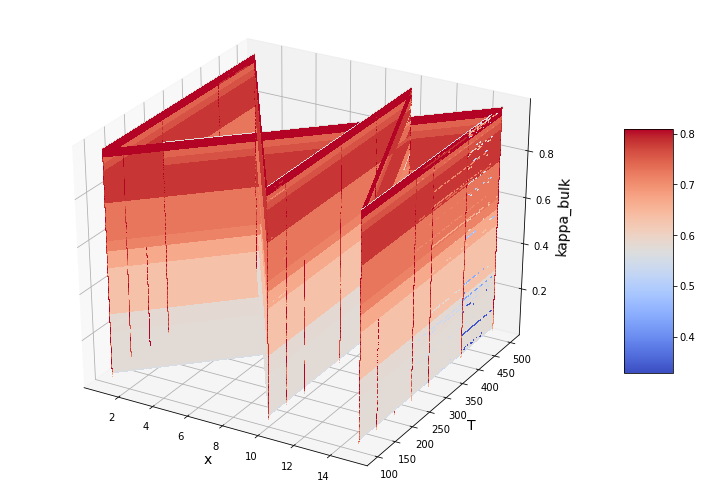

In [20]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
# т.к. у нас функция многих переменных (5) то можем построить хотя бы в 3мерном пространстве
def plot_3d(X, Y, z, X_label, Y_label, z_label, maxlen=1000):  
    # maxlen - количество данных для графика
    fancy = False

    if X.shape[0] > maxlen:
        # слычайный массив по диапозону от/до + сортируем (для получения возрастающих индексов)
        indicies = np.sort( np.random.randint(0, X.shape[0], size=maxlen))  
        fancy = True
    
    fig = plt.figure(figsize=(13,9))
    ax = fig.gca(projection='3d')

    if fancy:
        surf = ax.plot_surface(X[indicies], 
                               Y[indicies], 
                               z[indicies], 
                               cmap=cm.coolwarm,
                               linewidth=0, 
                               antialiased=False)
    else:
        surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(X_label, fontsize=14)
    ax.set_ylabel(Y_label, fontsize=14)
    ax.set_zlabel(z_label, fontsize=14)

idx1 = 1
idx2 = 3
plot_3d(X[columns[idx1]], X[columns[idx2]], y, columns[idx1], columns[idx2],  y_column)

In [8]:
# ф-ция для сравнения результатов двух моделей (строит два графика для сравеннеия)
def plot_comparision(X1, X2, y1, y2, x_label, y_label, scale=False):
    """
    X1.shape == y1.shape
    X2.shape == y2.shape
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

    
    if scale:
        y_min = min( min(y1), min(y2))
        y_max = max( max(y1), max(y2))

    col = 0
    axs[col].plot(X1,y1)
    axs[col].set_xlabel(x_label)
    axs[col].set_ylabel(y_label)
    axs[col].grid(True)
    if scale:
        axs[col].set_ylim(y_min, y_max)

    col = 1   
    axs[col].plot(X2,y2)
    axs[col].set_xlabel(x_label)
    axs[col].set_ylabel(y_label)
    axs[col].grid(True)
    if scale:
        axs[col].set_ylim(y_min, y_max)

In [9]:
# Keras model
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

# количество входных переменных
inp_size = X.shape[1]
out_size = y.shape[1]

base = (inp_size + out_size) * math.log(X.shape[0], 2)
L1_size = int( base * 3 )
L2_size = int( base * 2 )
L3_size = int( base * 1 )

# Initialisation of the NN
model = Sequential()  # последовательная модель

# Input layer and the first hidden layer
# Dense - обычный слой многослойного персептрона
model.add(Dense(L1_size, activation = 'relu', input_dim = X.shape[1])) #, kernel_initializer=RandomNormal(stddev=0.001)))

# Second hidden layer
model.add(Dense(units = L2_size, activation = 'relu')) #, kernel_initializer=RandomNormal(stddev=0.001)))

# Third hidden layer
model.add(Dense(units = L3_size, activation = 'relu')) #, kernel_initializer=RandomNormal(stddev=0.001)))

# Output layer
model.add(Dense(units = 1))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 277)               1939      
_________________________________________________________________
dense_1 (Dense)              (None, 185)               51430     
_________________________________________________________________
dense_2 (Dense)              (None, 92)                17112     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 93        
Total params: 70,574
Trainable params: 70,574
Non-trainable params: 0
_________________________________________________________________


In [11]:
%%time
adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
history = model.fit(X, y, epochs=10)

Epoch 1/10
302/302 [==============================] - 1s 2ms/step - loss: 5.8327 - mse: 5.8327
Epoch 2/10
302/302 [==============================] - 1s 2ms/step - loss: 0.0218 - mse: 0.0218
Epoch 3/10
302/302 [==============================] - 1s 2ms/step - loss: 0.0173 - mse: 0.0173
Epoch 4/10
302/302 [==============================] - 1s 2ms/step - loss: 0.0113 - mse: 0.0113
Epoch 5/10
302/302 [==============================] - 1s 2ms/step - loss: 0.0107 - mse: 0.0107
Epoch 6/10
302/302 [==============================] - 1s 2ms/step - loss: 0.0271 - mse: 0.0271
Epoch 7/10
302/302 [==============================] - 1s 2ms/step - loss: 0.0262 - mse: 0.0262
Epoch 8/10
302/302 [==============================] - 1s 2ms/step - loss: 0.0815 - mse: 0.0815
Epoch 9/10
302/302 [==============================] - 1s 2ms/step - loss: 0.0402 - mse: 0.0402
Epoch 10/10
302/302 [==============================] - 1s 2ms/step - loss: 0.0266 - mse: 0.0266
CPU times: user 9.43 s, sys: 902 ms, total: 10.3 

In [12]:
y_keras = model.predict(X)

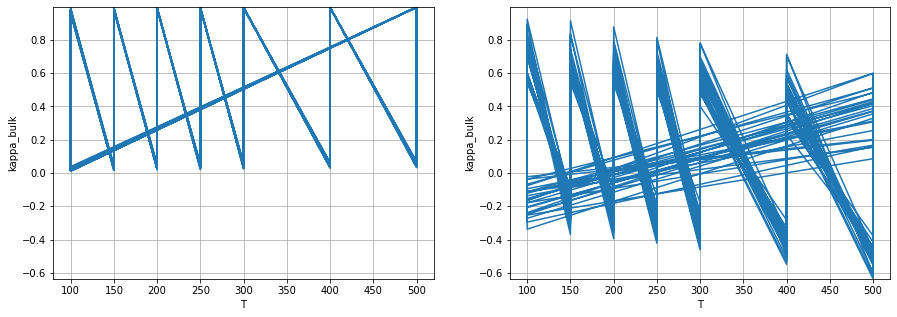

In [15]:
idx = 3
plot_comparision(X[columns[idx]],
                 X[columns[idx]], 
                 y,
                 y_keras,
                 columns[idx],
                 y_column,
                 scale=True)

In [16]:
model.evaluate(X_scaled, y_scaled)

302/302 [==============================] - 0s 1ms/step - loss: 0.8161 - mse: 0.8161


[0.8160576224327087, 0.8160576224327087]

0.7145399380657708


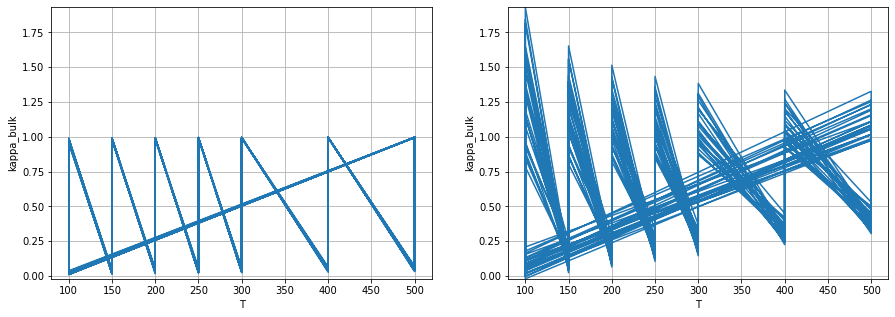

In [17]:
# Linear Regression
linreg = linear_model.LinearRegression().fit(X_scaled, y_scaled)  
print(linreg.score(X_scaled, y_scaled))
y_pred_lr = linreg.predict(X_scaled)
plot_comparision(X[columns[idx]],
                 X[columns[idx]], 
                 y,
                 y_scaler.inverse_transform(y_pred_lr),
                 columns[idx],
                 y_column,
                 scale=True)

-2.7588029449332314


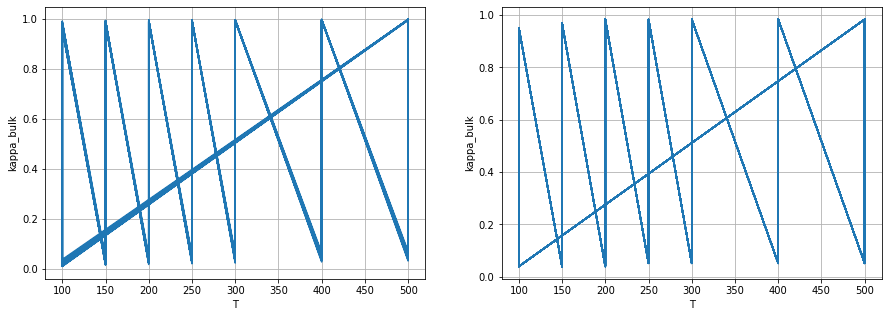

In [19]:
# Лес
from sklearn.ensemble import RandomForestRegressor
randForest = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=0)
randForest.fit(X_scaled, y_scaled)
print(randForest.score(X, y))
y_pred_for = randForest.predict(X_scaled)
plot_comparision(X[columns[idx]],
                 X[columns[idx]], 
                 y,
                 y_scaler.inverse_transform(y_pred_for),
                 columns[idx],
                 y_column)

Выводы:    
  Наилучший результат получен моделью RandomForestRegressor(n_estimators=10, max_depth=5, random_state=0)